<a href="https://colab.research.google.com/github/jitendra-121/brain_tumor_segmentation/blob/main/brain_tumor_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
#

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [3]:
!kaggle datasets download -d nikhilroxtomar/brain-tumor-segmentation

Dataset URL: https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation
License(s): unknown
100% 311M/312M [00:19<00:00, 17.0MB/s]
100% 312M/312M [00:19<00:00, 16.4MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/brain-tumor-segmentation.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

### About Dataset

The dataset contains 3064 pairs of MRI brain images and their respective binary mask indicating tumor.

This dataset is the Figshare Brain Tumor dataset. Link to the original dataset: https://figshare.com/articles/dataset/brain_tumor_dataset/1512427

In [5]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanIoU
import matplotlib.pyplot as plt

# Define the image size
IMAGE_SIZE = (128, 128)

# Paths to your image and mask folders
image_dir = '/content/images'
mask_dir = '/content/masks'

# Load images and masks from the folders
def load_data(image_dir, mask_dir, img_size=IMAGE_SIZE):
    images = []
    masks = []

    # Load images
    for filename in os.listdir(image_dir):
        img = load_img(os.path.join(image_dir, filename), target_size=img_size, color_mode="grayscale")
        img = img_to_array(img) / 255.0  # Normalize to [0, 1]
        images.append(img)

    # Load masks
    for filename in os.listdir(mask_dir):
        mask = load_img(os.path.join(mask_dir, filename), target_size=img_size, color_mode="grayscale")
        mask = img_to_array(mask) / 255.0  # Normalize to [0, 1]
        masks.append(mask)

    return np.array(images), np.array(masks)

# Load data
images, masks = load_data(image_dir, mask_dir)



In [7]:
images.shape, masks.shape

((3064, 128, 128, 1), (3064, 128, 128, 1))

In [9]:
type(images), type(masks)

(numpy.ndarray, numpy.ndarray)

In [10]:
images[0].shape, masks[0].shape

((128, 128, 1), (128, 128, 1))

In [11]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

# Build the U-Net model
def unet_model(input_size=(128, 128, 1)):
    inputs = Input(input_size)

    # Encoder (Contracting Path)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder (Expanding Path)
    u5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model



In [19]:
# Initialize and compile the model
model = unet_model()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32
                    )

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc * 100:.2f}%")

# Calculate Intersection over Union (IoU) for test data
y_pred = model.predict(X_test)
y_pred_thresholded = (y_pred > 0.5).astype(np.uint8)

iou_metric = MeanIoU(num_classes=2)
iou_metric.update_state(y_test, y_pred_thresholded)
print("Mean IoU =", iou_metric.result().numpy())



Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 97s 688ms/step - accuracy: 0.9761 - loss: 0.1804
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 75s 331ms/step - accuracy: 0.9836 - loss: 0.0602
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 25s 322ms/step - accuracy: 0.9835 - loss: 0.0526
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 40s 314ms/step - accuracy: 0.9857 - loss: 0.0456
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 42s 329ms/step - accuracy: 0.9870 - loss: 0.0384
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 40s 317ms/step - accuracy: 0.9878 - loss: 0.0358
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 42s 325ms/step - accuracy: 0.9884 - loss: 0.0325
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 25s 322ms/step - accuracy: 0.9895 - loss: 0.0289
Epoch 9/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 40s 315ms/step - accuracy: 0.9904 - loss: 0.0259
Epoch 10/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 42s 327ms/step - accuracy: 0.9915 - loss: 0.0229
Epoch 11/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 40s 318ms/step - accuracy: 0.9920 - loss: 0.0208
Epoch 12/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 41

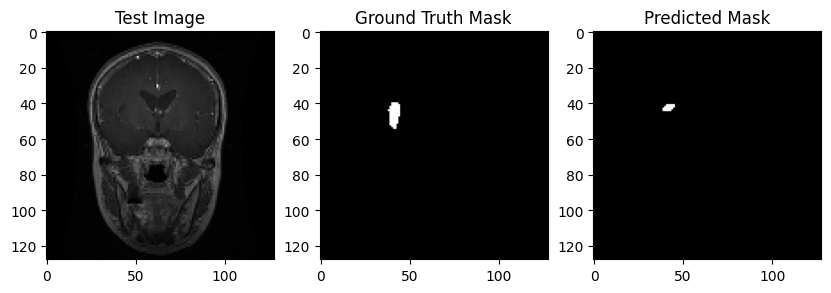

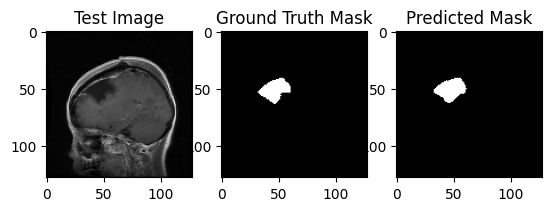

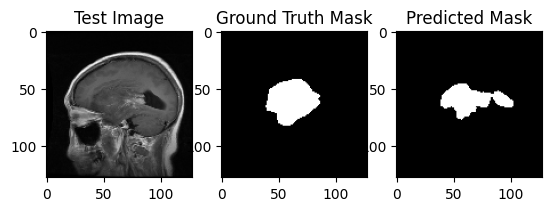

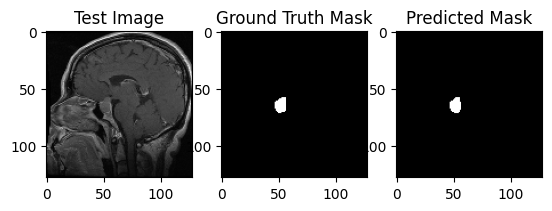

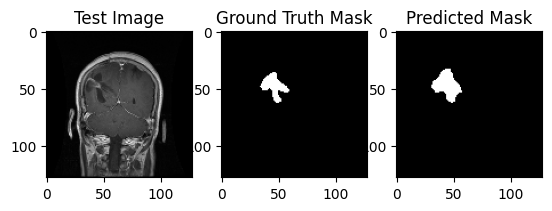

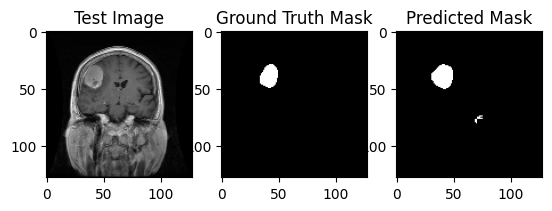

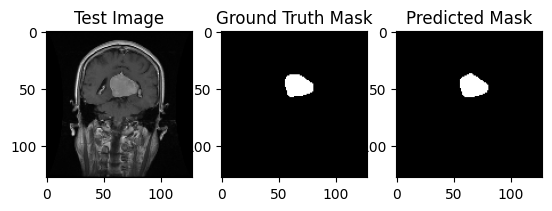

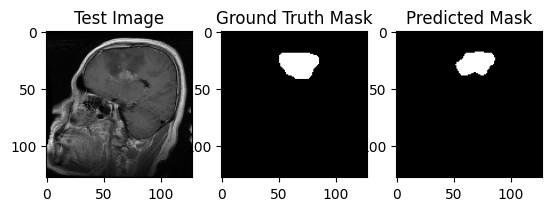

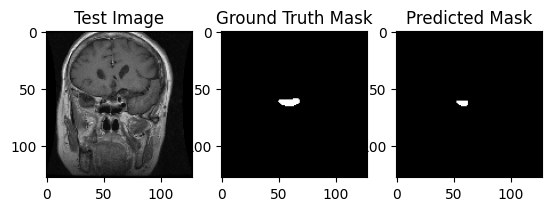

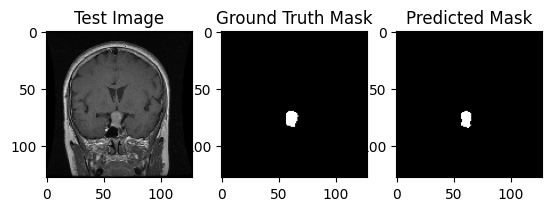

In [20]:
# Visualize a test image and its predicted mask
plt.figure(figsize=(10, 10))

# Original image

for i in range(10):
  plt.subplot(1, 3, 1)
  plt.title("Test Image")
  plt.imshow(X_test[i].reshape(IMAGE_SIZE), cmap='gray')
  # Ground truth mask
  plt.subplot(1, 3, 2)
  plt.title("Ground Truth Mask")
  plt.imshow(y_test[i].reshape(IMAGE_SIZE), cmap='gray')
  # Predicted mask
  plt.subplot(1, 3, 3)
  plt.title("Predicted Mask")
  plt.imshow(y_pred_thresholded[i].reshape(IMAGE_SIZE), cmap='gray')

  plt.show()





In [ ]:
# know models architecture and parameters
# tweek modelactivation
# know more about evaluation metrics
# cheak for overfitting
# edit model cange it